<a href="https://colab.research.google.com/github/Viraj911/Multi_Model_Hate_Speech_using_Deep_Learning./blob/main/Multi_Model_Hate_Speech_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import VGG16, ResNet50
from keras.applications.efficientnet import EfficientNetB0
from transformers import BertTokenizer, TFBertModel

In [124]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [125]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/Training_meme_dataset.csv')
df_new = df.copy()

In [126]:
df.shape


(742, 3)

In [127]:
df.duplicated().sum()

0

In [128]:
df.isnull().sum()

image_name    0
sentence      0
label         0
dtype: int64

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  742 non-null    object
 1   sentence    742 non-null    object
 2   label       742 non-null    object
dtypes: object(3)
memory usage: 17.5+ KB


In [130]:
df.nunique()

image_name    742
sentence      742
label           2
dtype: int64

In [131]:
df['label'].unique()

array(['Non-offensiv', 'offensive'], dtype=object)

In [132]:
df['label'].value_counts()

label
Non-offensiv    440
offensive       302
Name: count, dtype: int64

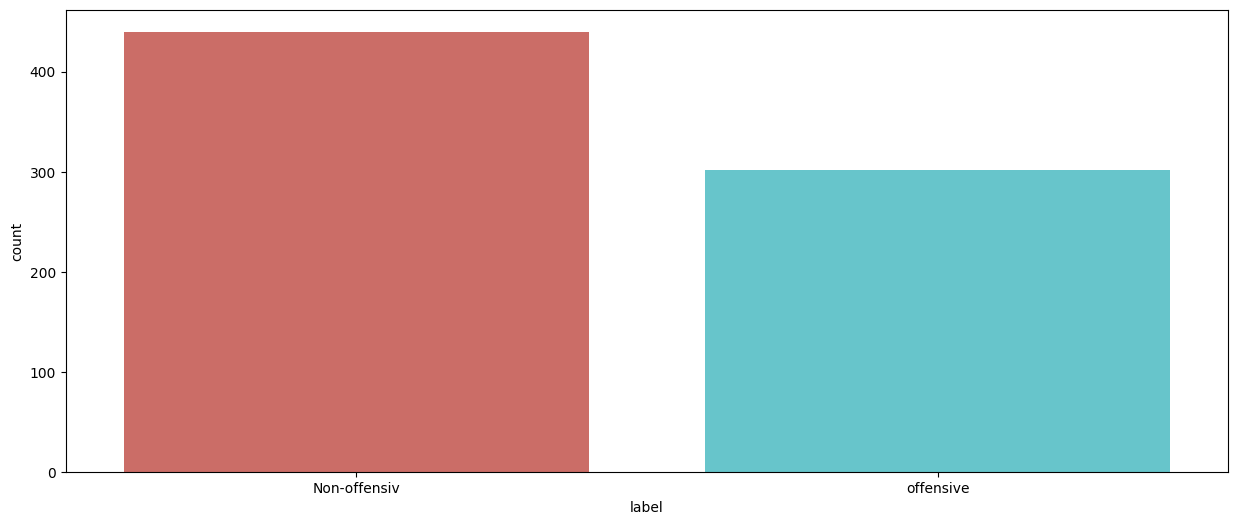

In [133]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'label', data = df, palette = 'hls')
plt.show()

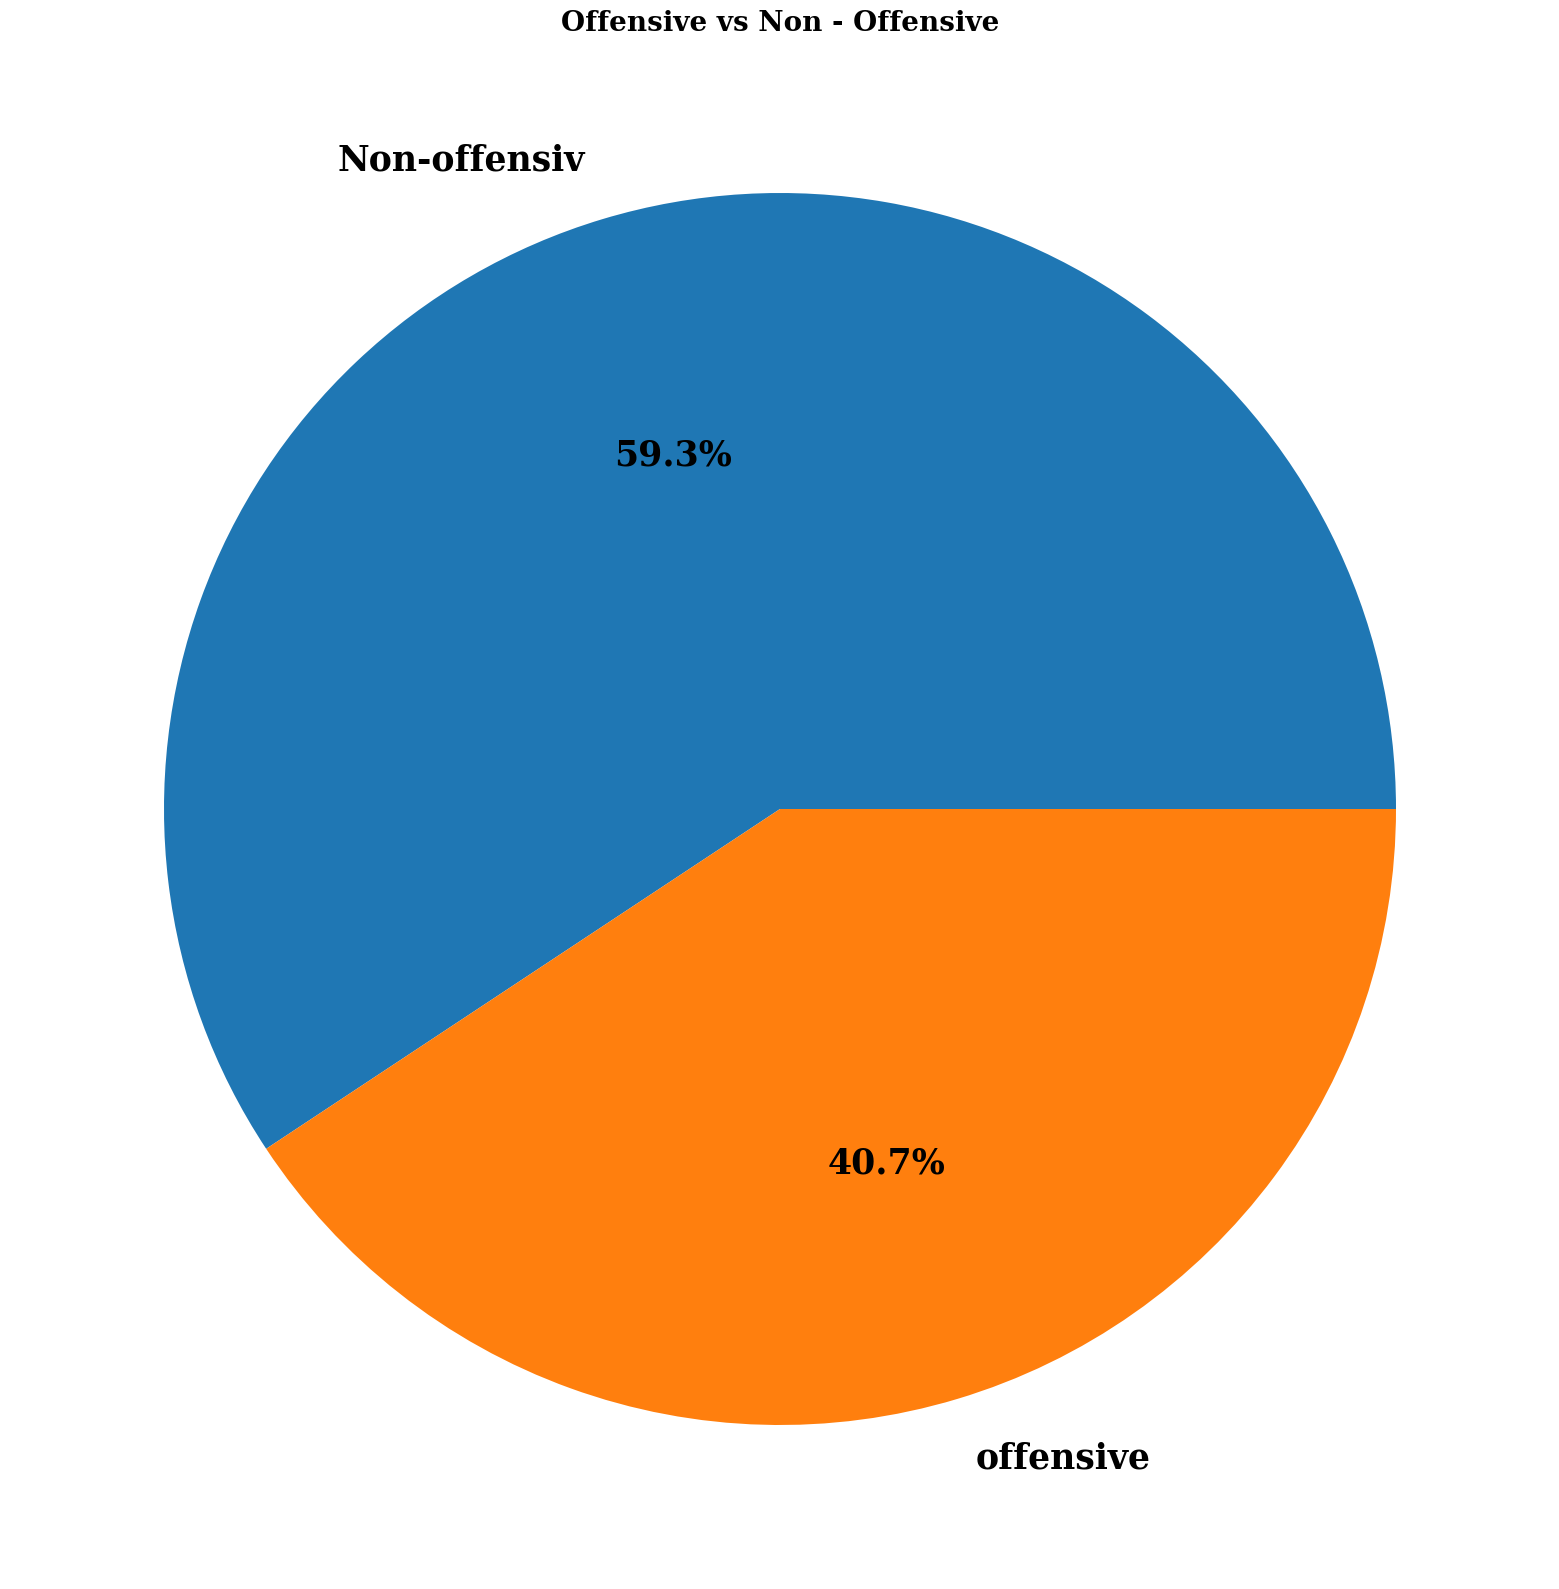

In [134]:
plt.figure(figsize=(30,20))
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index,
        autopct='%1.1f%%', textprops={ 'fontsize': 25,
                                       'color': 'black',
                                        'weight': 'bold',
                                        'family': 'serif' })
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Offensive vs Non - Offensive', size=20, **hfont)
plt.show()

In [135]:
# Text preprocessing with Lemmatization
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\S*\d\S*\s*', '', text)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

In [136]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [137]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return ' '.join(lemmatized_tokens)

In [138]:
df_new['lemmatized_sentence'] = df_new['sentence'].apply(clean_text).apply(remove_punctuation).apply(lemmatize_text)


In [139]:
df_new['lemmatized_sentence']

0      official bernie sander drinking game every tim...
1      pm iswall insidenazi gas chamber dwebs whendem...
2                          shit waddup bernie sander com
3      mitt romney worst republican country putup bar...
4      anonymous id fri file image jpg kb repeating d...
                             ...                        
737       pussy almost brings trump weiner knock clinton
738    clinton said shebringing back rugratis going uote
739    hr awkward moment bernie sander admits isdemoc...
740    hillary blood hand stop voting fear vote green...
741    debate site st louis pm ct hara entspizz break...
Name: lemmatized_sentence, Length: 742, dtype: object

In [140]:
# Image preprocessing
def load_and_preprocess_images(image_folder, image_names, target_size):
    images = []
    for image_name in image_names:
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, target_size)
            image = image / 255.0
            images.append(image)
    return np.array(images)

In [141]:
image_folder_path = "/content/drive/MyDrive/Dataset/Labelled Images"
image_width, image_height = 224, 224
image_names = df_new['image_name']
images = load_and_preprocess_images(image_folder_path, image_names, (image_width, image_height))


In [142]:
# Split data
train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(
    df_new['lemmatized_sentence'], images, df_new['label'], stratify=df_new['label'], test_size=0.2, random_state=42
)

In [143]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
vocab_size = len(tokenizer.word_index) + 1
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_texts), padding='post')
test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_texts), padding='post')


In [144]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [149]:

# Define function to create multimodal models
def create_multimodal_model(text_model_architecture, image_model_architecture):
    # Text model
    text_input = Input(shape=(train_sequences.shape[1],))
    text_embedding = Embedding(input_dim=vocab_size, output_dim=100)(text_input)

    if text_model_architecture == 'LSTM':
        text_output = LSTM(128)(text_embedding)
    elif text_model_architecture == 'BiLSTM':
        text_output = Bidirectional(LSTM(128))(text_embedding)
    elif text_model_architecture == 'BiLSTM_Dropout':
        text_embedding = SpatialDropout1D(0.2)(text_embedding)
        text_output = Bidirectional(LSTM(128, return_sequences=True))(text_embedding)
        text_output = Bidirectional(LSTM(128))(text_output)
    else:
        raise ValueError("Invalid text model architecture specified.")

    # Image model
    image_input = Input(shape=(image_width, image_height, 3))
    if image_model_architecture == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
        for layer in base_model.layers:
            layer.trainable = False
        image_output = base_model(image_input)
        image_output = Flatten()(image_output)
    elif image_model_architecture == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
        for layer in base_model.layers:
            layer.trainable = False
        image_output = base_model(image_input)
        image_output = Flatten()(image_output)
    elif image_model_architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
        for layer in base_model.layers:
            layer.trainable = False
        image_output = base_model(image_input)
        image_output = GlobalAveragePooling2D()(image_output)
    else:
        raise ValueError("Invalid image model architecture specified.")

    # Concatenate text and image features
    concatenated = concatenate([text_output, image_output])
    dense1 = Dense(128, activation='relu')(concatenated)
    dense2 = Dense(60, activation='relu')(dense1)
    dense3 = Dense(30, activation='relu')(dense2)
    output = Dense(1, activation='sigmoid')(dense3)

    # Create and compile model
    model = Model(inputs=[text_input, image_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [150]:
# Define model architectures to evaluate
model_architectures = [
    ('LSTM', 'VGG16'),
    ('BiLSTM', 'ResNet50'),
    ('BiLSTM_Dropout', 'EfficientNetB0')
]

Epoch 1/10
15/15 [==============================] - 11s 471ms/step - loss: 0.7337 - accuracy: 0.5316 - val_loss: 0.6920 - val_accuracy: 0.5294
Epoch 2/10
15/15 [==============================] - 8s 525ms/step - loss: 0.4876 - accuracy: 0.7658 - val_loss: 0.7966 - val_accuracy: 0.5546
Epoch 3/10
15/15 [==============================] - 7s 452ms/step - loss: 0.3117 - accuracy: 0.9072 - val_loss: 0.9521 - val_accuracy: 0.5882
Epoch 4/10
15/15 [==============================] - 8s 529ms/step - loss: 0.2631 - accuracy: 0.8903 - val_loss: 0.9518 - val_accuracy: 0.5294
Epoch 5/10
15/15 [==============================] - 6s 396ms/step - loss: 0.1504 - accuracy: 0.9494 - val_loss: 1.0391 - val_accuracy: 0.5042
Epoch 6/10
15/15 [==============================] - 7s 468ms/step - loss: 0.0915 - accuracy: 0.9662 - val_loss: 1.1289 - val_accuracy: 0.5378
Epoch 7/10
15/15 [==============================] - 6s 387ms/step - loss: 0.0610 - accuracy: 0.9768 - val_loss: 1.2395 - val_accuracy: 0.5126
Epoch

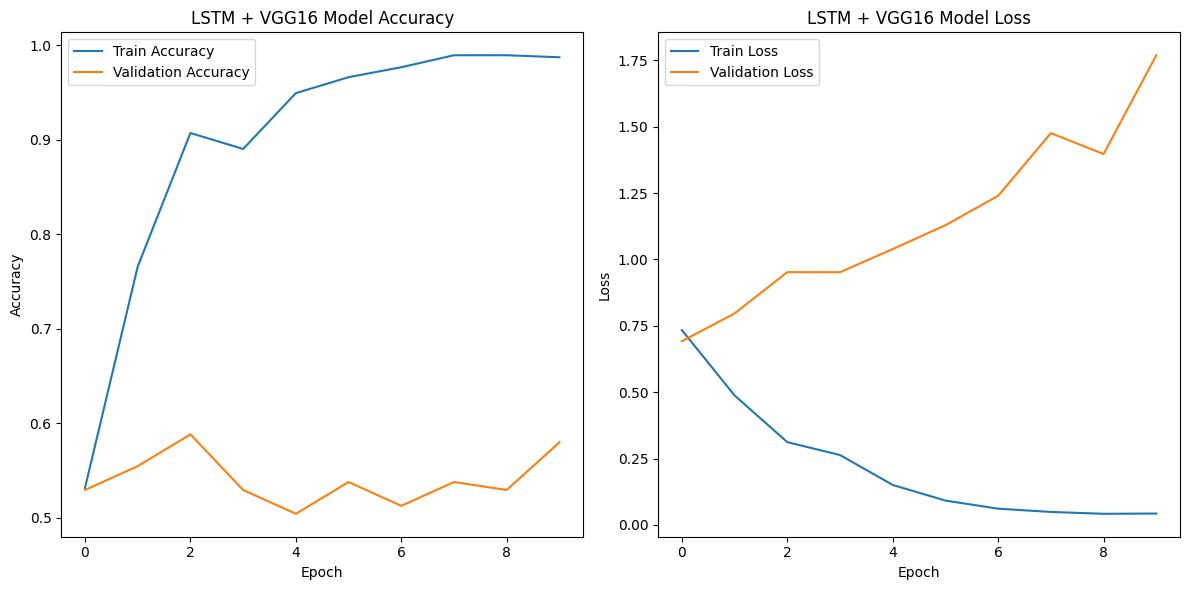

Epoch 1/10
15/15 [==============================] - 18s 745ms/step - loss: 1.7190 - accuracy: 0.5105 - val_loss: 0.8736 - val_accuracy: 0.6050
Epoch 2/10
15/15 [==============================] - 8s 537ms/step - loss: 0.8260 - accuracy: 0.5422 - val_loss: 1.1836 - val_accuracy: 0.6050
Epoch 3/10
15/15 [==============================] - 9s 612ms/step - loss: 0.8524 - accuracy: 0.5633 - val_loss: 0.8179 - val_accuracy: 0.4454
Epoch 4/10
15/15 [==============================] - 9s 596ms/step - loss: 0.8495 - accuracy: 0.5612 - val_loss: 0.7469 - val_accuracy: 0.5210
Epoch 5/10
15/15 [==============================] - 8s 509ms/step - loss: 0.6928 - accuracy: 0.6435 - val_loss: 0.7855 - val_accuracy: 0.6555
Epoch 6/10
15/15 [==============================] - 9s 585ms/step - loss: 0.4081 - accuracy: 0.8165 - val_loss: 0.8712 - val_accuracy: 0.5546
Epoch 7/10
15/15 [==============================] - 7s 489ms/step - loss: 0.2540 - accuracy: 0.9156 - val_loss: 0.7865 - val_accuracy: 0.6218
Epoch

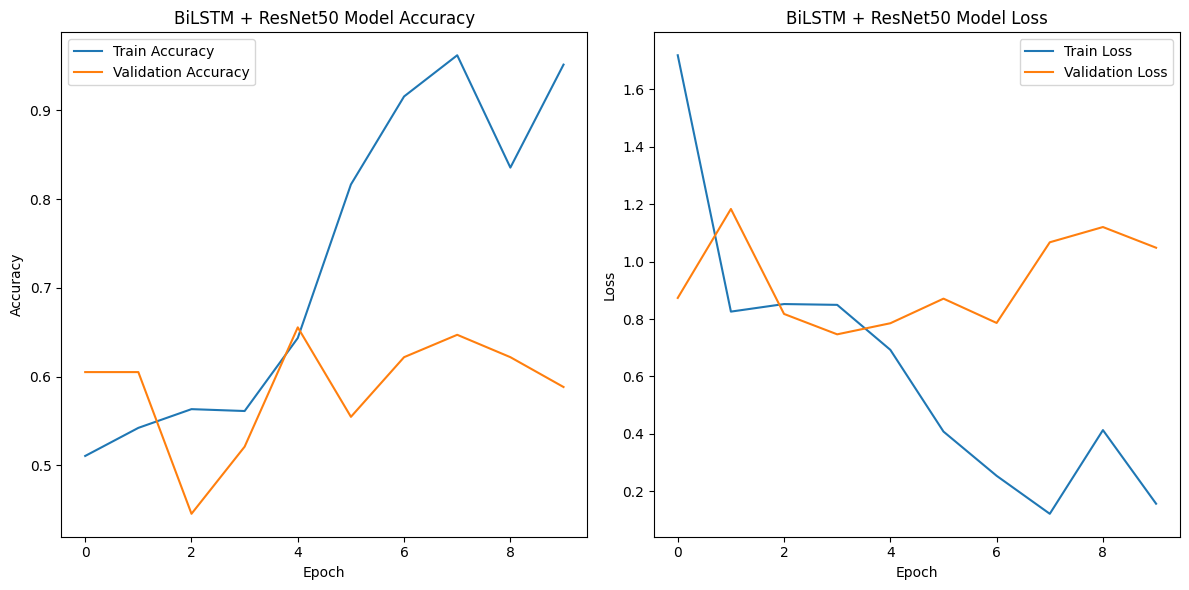

Epoch 1/10
15/15 [==============================] - 29s 1s/step - loss: 0.6829 - accuracy: 0.5738 - val_loss: 0.6753 - val_accuracy: 0.6050
Epoch 2/10
15/15 [==============================] - 14s 894ms/step - loss: 0.6810 - accuracy: 0.5907 - val_loss: 0.6706 - val_accuracy: 0.6050
Epoch 3/10
15/15 [==============================] - 17s 1s/step - loss: 0.6620 - accuracy: 0.5949 - val_loss: 0.6579 - val_accuracy: 0.6218
Epoch 4/10
15/15 [==============================] - 14s 929ms/step - loss: 0.3976 - accuracy: 0.8797 - val_loss: 0.7324 - val_accuracy: 0.6303
Epoch 5/10
15/15 [==============================] - 14s 929ms/step - loss: 0.1683 - accuracy: 0.9515 - val_loss: 1.3183 - val_accuracy: 0.6807
Epoch 6/10
15/15 [==============================] - 14s 914ms/step - loss: 0.1602 - accuracy: 0.9578 - val_loss: 1.0407 - val_accuracy: 0.5882
Epoch 7/10
15/15 [==============================] - 14s 927ms/step - loss: 0.1353 - accuracy: 0.9641 - val_loss: 1.2391 - val_accuracy: 0.6387
Epoch

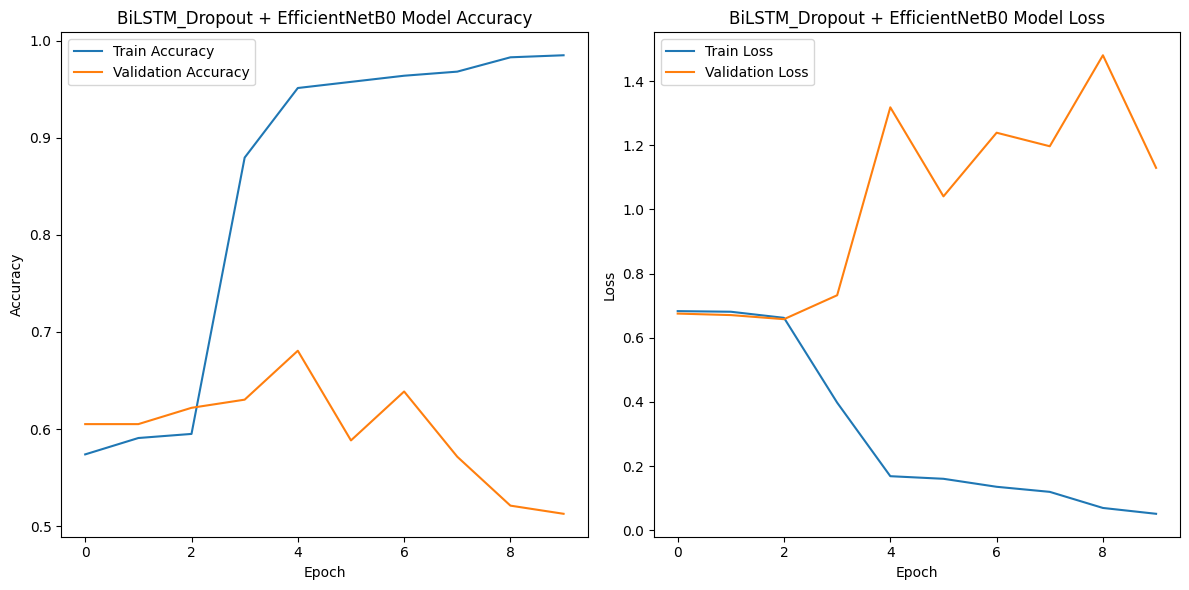

In [151]:
# Train and evaluate models
results = {}
for text_arch, image_arch in model_architectures:
    model = create_multimodal_model(text_arch, image_arch)
    history = model.fit([train_sequences, train_images], train_labels_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate model
    _, accuracy = model.evaluate([test_sequences, test_images], test_labels_encoded, verbose=0)
    results[(text_arch, image_arch)] = accuracy

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{text_arch} + {image_arch} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{text_arch} + {image_arch} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [152]:
# Print results
print("Model Evaluation Results:")
for (text_arch, image_arch), acc in results.items():
    print(f"({text_arch} + {image_arch}): Accuracy = {acc:.4f}")

Model Evaluation Results:
(LSTM + VGG16): Accuracy = 0.5772
(BiLSTM + ResNet50): Accuracy = 0.5973
(BiLSTM_Dropout + EfficientNetB0): Accuracy = 0.5369
